<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/fourier_forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier decomposition and forecasting
Under stationarity assumption, Fourier decomposition can be used to extrapolate a signal beyond observed values. In this lesson you'll write a simple Fourier forecaster from scratch. Let's start downloading some time series


In [1]:
%%capture
!pip install wget
!pip install seaborn
!pip install statsmodels==0.12.2
!pip install tabulate
import pandas as pd
import wget
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_pickle(wget.download("https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"));


We'll try to forecast the first signal

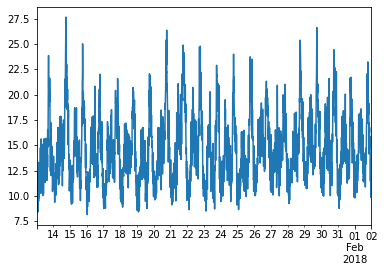

In [2]:
data.iloc[:144*20, 0].plot();

The following code just creates the first $n_h$ basis functions defined as: 
$$\left[sin\left(\frac{2\pi tk}{l}\right), cos\left(\frac{2\pi tk}{l}\right)\right] \quad k\in \{1,\dots n_h\}$$
where $l$ is the length of $t \in \mathbb{N}^l$.

We then see that the cross-covariance matrix of these basis functions is normal, that is, off-diagonal elements are 0. 

In order to obtain an orthonormal basis we just need to divide P by the signals variances, that is, its diagonal entries. As you can see in this case all diagonal elements are the same and equal to $l/2$. 

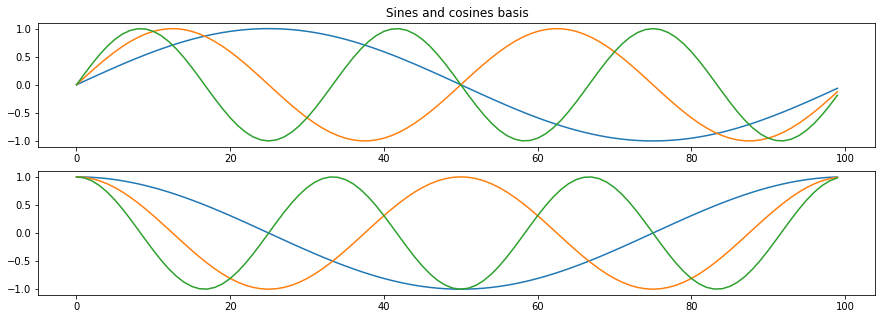

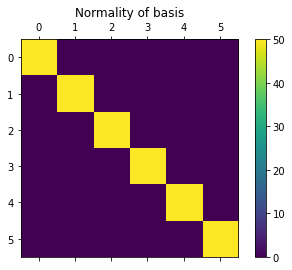

In [3]:
l=100               # lenght of the signal
n_h = 3             # number of harmonics to plot
t = np.arange(l)    # time vector

def get_basis(t, l, n_h):
  """
  Get the first n_h sine and cosine basis functions and the projection 
  matrix P
  """
  sines = np.vstack([np.sin(2*np.pi*k*t/l) for k in np.arange(n_h)+1])
  cosines = np.vstack([np.cos(2*np.pi*k*t/l) for k in np.arange(n_h)+1])
  P = np.vstack([sines, cosines]).T
  return P, sines, cosines

P, sines, cosines = get_basis(t, l, n_h)

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].plot(sines.T)
ax[1].plot(cosines.T)
ax[0].set_title('Sines and cosines basis')

fig, ax = plt.subplots()
m = ax.matshow(P.T@P)
plt.colorbar(m)
ax.set_title('Normality of basis', y=1.0);


The following is just an utility function to remove the mean from the power signal and return a training and a test set.

In [4]:
def get_tr_te(p, training_steps, steps_ahead):
  x_tr = p.iloc[:training_steps].values
  tr_mean = np.mean(x_tr)
  x_tr -= tr_mean 
  x_te = p.iloc[training_steps:training_steps+steps_ahead].values
  x_te -= tr_mean
  return x_tr, x_te

p = data.iloc[:, 0].copy()
steps_ahead = 144*7
training_steps = 144*7

x_tr, x_te = get_tr_te(p, training_steps, steps_ahead)

# ❓ Write a Fourier forecaster
Once you have created the basis function with the same length of the training signal, you have to project the original signal onto the basis. Since the basis matrix is normal and diagonal, we can obtain the orthonormal basis as 
$$P_n = 2P/l$$ 
Now the linear regression can be achieved by just 
$$\beta = (P_n^TP_n)^{-1}(P_n^Tx) =I(P_n^Tx)=
 P_n^Tx$$

In order to extrapolate you just have to create a longer basis matrix $P$ and obtain the extrapolated signal using $\beta$.


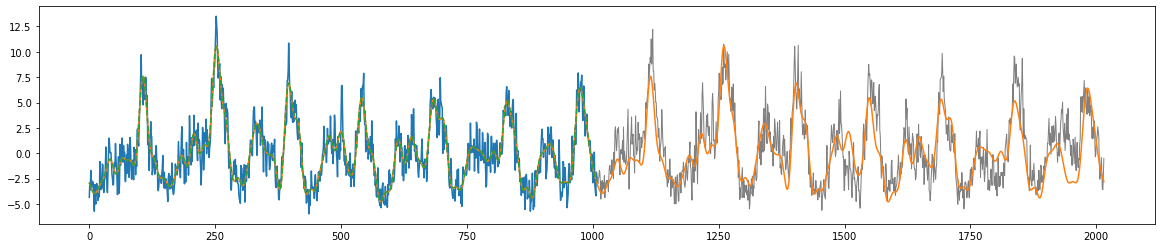

In [13]:
l=len(x_tr)
n_h = 50
t = np.arange(l)

P, sines, cosines = get_basis(t, l, n_h)
#coeffs = np.linalg.inv(P.T@P)@(P.T@x_tr) 
coeffs = P.T@x_tr/l*2                      # since the basis is orthonormal this is equivalent to the above expression


t = np.arange(l+len(x_te)) 
P_pred, sines, cosines = get_basis(t, l, n_h)

plt.subplots(1, 1, figsize=(20, 4))
plt.plot(x_tr)
plt.plot(np.hstack([x_tr*np.nan, x_te]), color='grey', linewidth=1)
plt.plot(P_pred@coeffs);
plt.plot(P@coeffs, linestyle='--');


# Efficient implementation
The fast Fourier transform (FFT) can be used to implement an efficient version of the toy code you just crafted. The FFT returns the complex numbers encoding frequencies and phases for a signal $x$. Since the FFT obtain these coefficeint through windowing, in this case we also need to consider phases when reconstructing the original signal.

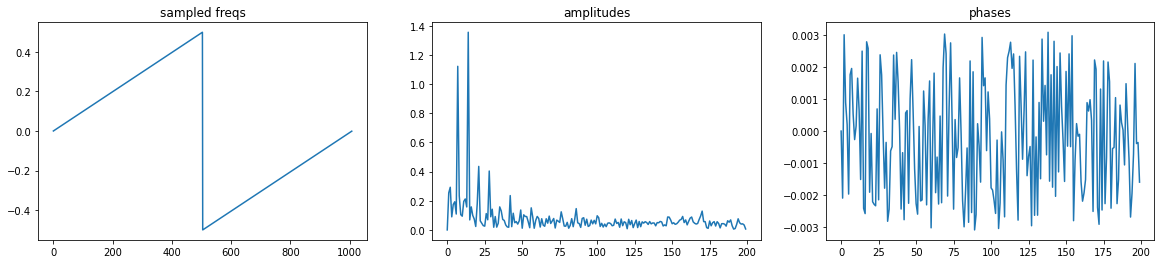

In [15]:
from numpy import fft
x_freqdom = fft.fft(x_tr)

fig, ax = plt.subplots(1, 3, figsize=(20, 4))
ax[0].plot(fft.fftfreq(l))
ax[1].plot(np.absolute(x_freqdom)[:200] / l)
ax[2].plot(np.angle(x_freqdom)[:200] / l)
[a.set_title(t) for a, t in zip(ax, ['sampled freqs', 'amplitudes', 'phases'])];


In [18]:
def fourierExtrapolation(x, n_predict, n_h=10):
    n = x.size
    x_freqdom = fft.fft(x)  # x in frequency domain
    f = fft.fftfreq(n)      # frequencies

    # sort indexes by frequency, lower -> higher
    indexes = np.argsort(np.absolute(f))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_h * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig

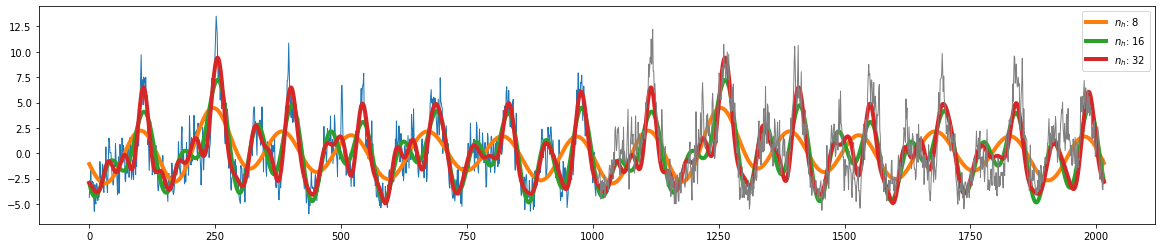

In [19]:
plt.subplots(1, 1, figsize=(20, 4))
plt.plot(x_tr, linewidth=1)
for n_h in [8, 16, 32]:
  plt.plot(fourierExtrapolation(x_tr, steps_ahead, n_h), label='$n_h$: {}'.format(n_h), linewidth=4)
plt.plot(np.hstack([x_tr*np.nan, x_te]), color='grey', linewidth=1)
plt.legend()

# ❓ What's the optimal $n_h$?
Write a function to get the MAE on the test set, then write an optimizer to obtain the optimal value of $n_h$ 
